In [16]:
import pickle

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Simulation parameters
RUNS = 10
NETWORK_FILE = "./networks/network_15_6.pkl"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 10  # RWM process noise scaling constant
expf = 0.95  # Exponential forgetting param
reset_thresh = 10.0  # Filter reset threshold (Euclidean distance from centroid)

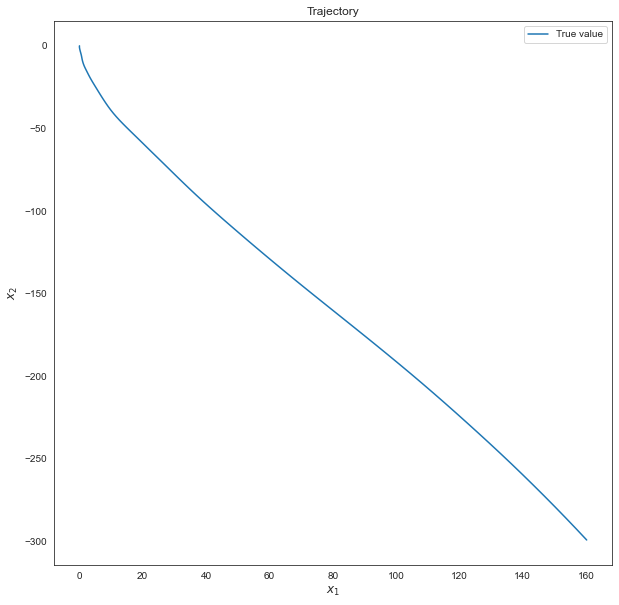

In [19]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [25]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=3.0,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

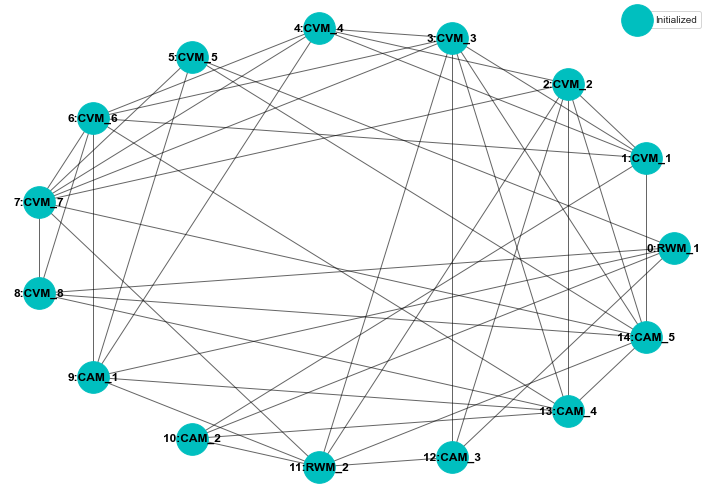

In [26]:
kfn.draw_network()

In [27]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

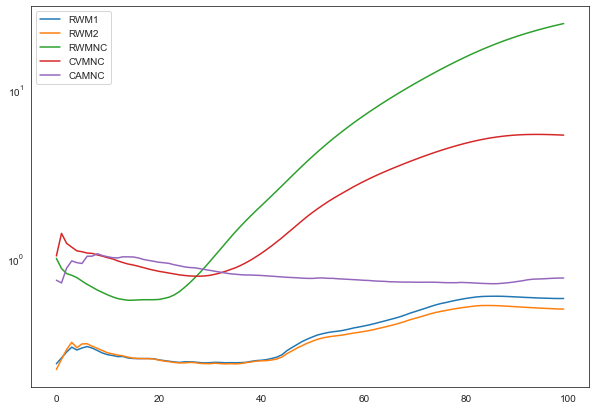

In [28]:
plt.figure(figsize=(10, 7))
plt.plot(rmse_rwm1[:, 0], label="RWM1")
plt.plot(rmse_rwm2[:, 0], label="RWM2")

plt.plot(rmse_rwmnc[:, 0], label="RWMNC")
plt.plot(rmse_cvmnc[:, 0], label="CVMNC")
plt.plot(rmse_camnc[:, 0], label="CAMNC")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [29]:
# Generate CSV files